# Skforecast: time series forecasting with Python, Machine Learning and Scikit-learn

- https://github.com/skforecast/skforecast
- https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

In [ ]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.14.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


## Data

The data used in the examples of this document have been obtained from the magnificent book Forecasting: [Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [ ]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True)

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [ ]:
data.head()

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


The column date has been stored as a string. To convert it to datetime the pd.to_datetime() function can be use. Once in datetime format, and to make use of Pandas functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as **Monthly Started** 'MS'.

In [ ]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


When using the asfreq() method in Pandas, any gaps in the time series will be filled with NaN values to match the specified frequency. Therefore, it is essential to check for any missing values that may occur after this transformation.

In [ ]:
# Missing values
# ==============================================================================
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Although it is unnecessary, since a frequency has been established, it is possible to verify that the time series is complete.

In [ ]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


The last 36 months are used as the test set to evaluate the predictive capacity of the model.

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


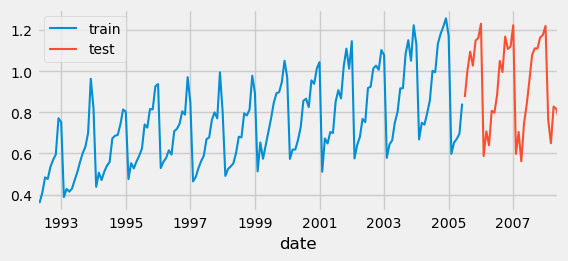

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

## Recursive multi-step forecasting

With the ForecasterRecursive class, a forecasting model is created and trained using a RandomForestRegressor regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

### ForecasterRecursive

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-01 15:42:28 
Last fit date: 2024-12-01 15:42:28 
Skforecast version: 0.14.0 
Python version: 3.10.13 
Forecaster id: None

### Prediction

Once the model is trained, the test data is predicted (36 months into the future).

In [ ]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

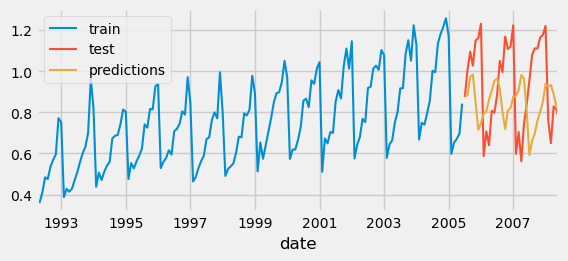

In [ ]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Forecasting error in the test set

To quantify the error the model makes in its predictions, the mean squared error (mse) metric is used.

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.07326833976120374


### Hyperparameter tuning

The trained ForecasterRecursive uses a 6 lags as predictors and a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model with the default hyperparameters. However, there is no reason why these values are the most suitable. Skforecast provide several [search strategies to find the best combination of hyperparameters and lags](https://skforecast.org/0.14.0/user_guides/hyperparameter-tuning-and-lags-selection.html). In this case, the grid_search_forecaster function is used. It compares the results obtained with each combinations of hyperparameters and lags, and identify the best one.

In [ ]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 36,
      initial_train_size = int(len(data_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,
    )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341


In [ ]:
# Search results
# ==============================================================================
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.021773,3,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 250}",0.022068,8,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 100}",0.023562,8,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.064241,3,250
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 250}",0.064546,8,250
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 100}",0.068730,8,100


The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 250}.

### Final model

Finally, a ForecasterRecursive is trained with the optimal configuration found. This step is not necessary if return_best is set to True in the grid_search_forecaster function.

In [ ]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data_train['y'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

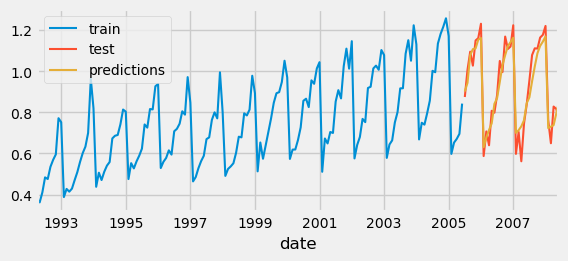

In [ ]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.004356831371529945


The optimal combination of hyperparameters significantly reduces test error.

### Backtesting

To obtain a robust estimate of the model's predictive capacity, a backtesting process is carried out. The process of backtesting consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation applied to the previous period(s).

For this example, a **Backtesting with Refit and Increasing Training Size (Fixed Origin)** strategy is followed. Internally, the process that the function applies is:

- In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are predicted.

- In the second iteration, the model is retrained by adding 36 observations to the initial training set (87 + 36), and then the next 36 observations are predicted.

- This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being pred

In [ ]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12 * 3, 
         initial_train_size = len(data) - 12 * 9,  # Last 9 years are separated for the backtest
         fixed_train_size   = False,
         refit              = True,
)
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
metric

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_squared_error
0,0.010233


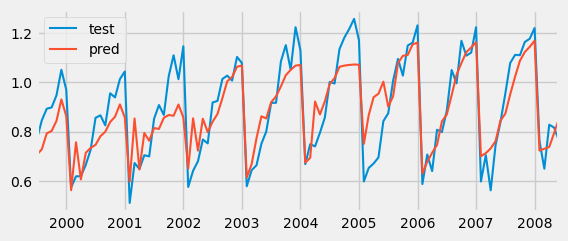

In [ ]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

### Model explanaibility (Feature importance)

Due to the complex nature of many modern machine learning models, such as ensemble methods, they often function as black boxes, making it difficult to understand why a particular prediction was made. Explanability techniques aim to demystify these models, providing insight into their inner workings and helping to build trust, improve transparency, and meet regulatory requirements in various domains. Enhancing model explainability not only helps to understand model behavior, but also helps to identify biases, improve model performance, and enable stakeholders to make more informed decisions based on machine learning insights.

Skforecast is compatible with some of the most popular model explainability methods: [model-specific feature importances, SHAP values, and partial dependence plots](https://skforecast.org/latest/user_guides/explainability).

#### Model-specific feature importance

In [ ]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importances()
importance.head(10)

,feature,importance
11,lag_12,0.815564
1,lag_2,0.086286
13,lag_14,0.019047
9,lag_10,0.013819
2,lag_3,0.012943
14,lag_15,0.009637
0,lag_1,0.009141
10,lag_11,0.008130
7,lag_8,0.007377
8,lag_9,0.005268


#### Shap values

SHAP (SHapley Additive exPlanations) values are a popular method for explaining machine learning models, as they help to understand how variables and values influence predictions visually and quantitatively.

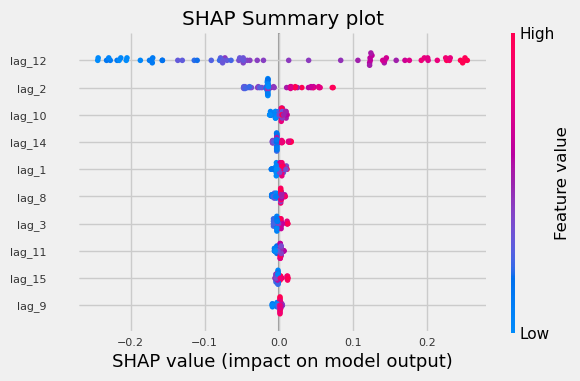

In [ ]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data_train['y'])

# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)
# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(6, 3.5)

## Forecasting with exogenous variables

In the previous example, only lags of the predicted variable itself were used as predictors. In certain scenarios, it is possible to have information about other variables, **whose future value is known**, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable is simulated whose behavior is correlated with the modeled time series and which is to be included as a predictor.

In [ ]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

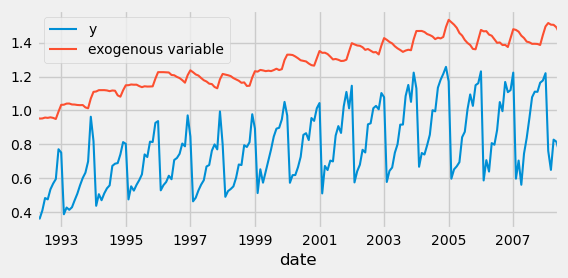

In [ ]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(6, 2.7))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend(loc='upper left');

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )
forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6 7 8] 
Window features: None 
Window size: 8 
Exogenous included: True 
Exogenous names: exog_1 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-01 15:56:54 
Last fit date: 2024-12-01 15:56:54 
Skforecast version: 0.14.0 
Python version: 3.10.13 
Forecaster id: None

Since the ForecasterRecursive has been trained with an exogenous variable, the value of this variable must be passed to predict(). The future information about the exogenous variable must be available at the time of prediction.

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

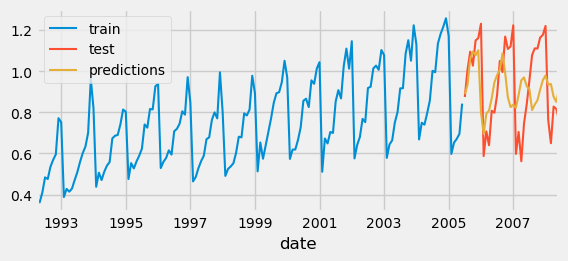

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.03989087922533575


## Window and custom features

When forecasting time series data, it may be useful to consider additional characteristics beyond just the lagged values. For example, the moving average of the previous n values may help to capture the trend in the series. The window_features argument allows the inclusion of additional predictors created with the previous values of the series.

In [ ]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


A new ForecasterRecursive is created and trained using a RandomForestRegressor regressor, this time including, in addition to the 10 lags, the moving average, maximum, minimum and standard deviation of the last 20 values in the series.

In [ ]:
# Window features
# ==============================================================================
window_features = RollingFeatures(
    stats = ['mean', 'std', 'min', 'max'],
    window_sizes = 20
)

# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor       = RandomForestRegressor(random_state=123),
                lags            = 10,
                window_features = window_features,
             )
forecaster.fit(y=data_train['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: ['roll_mean_20', 'roll_std_20', 'roll_min_20', 'roll_max_20'] 
Window size: 20 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-01 15:59:27 
Last fit date: 2024-12-01 15:59:28 
Skforecast version: 0.14.0 
Python version: 3.10.13 
Forecaster id: None

The create_train_X_y method provides access to the matrices generated internally during the predictor training process and used to fit the model. This allows the user to inspect the data and understand how the predictors were created.

In [ ]:
# Training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data_train['y'])
display(X_train.head(5))
display(y_train.head(5))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean_20,roll_std_20,roll_min_20,roll_max_20
date,,,,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089,0.122733,0.361801,0.771258
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253,0.152567,0.361801,0.963081
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129,0.156751,0.387554,0.963081
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486,0.155363,0.387554,0.963081
1994-04-01,0.506121,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.577622,0.154728,0.387554,0.963081


date
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
1994-04-01    0.470491
Freq: MS, Name: y, dtype: float64

In [ ]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

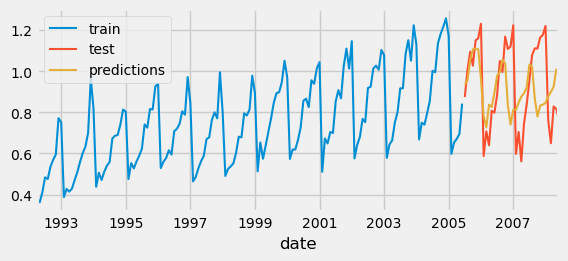

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.04180143590431811


## Direct multi-step forecasting

ForecasterRecursive models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the ForecasterDirect class and can include one or multiple exogenous variables.

### ForecasterDirect

Unlike when using ForecasterRecursive, the number of steps to be predicted must be indicated in the ForecasterDirect. This means that it is not possible to predict steps beyond the value defined at their creation when executing the predict() method.

For this example, a linear model with Ridge penalty is used as a regressor. These models require the predictors to be standardized, so it is combined with a StandardScaler.

For more detailed documentation how to use transformers and pipelines, visit: [skforecast with scikit-learn and transformers pipelines](https://skforecast.org/latest/user_guides/sklearn-transformers-and-pipeline.html).

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 steps         = 36,
                 lags          = 8,
                 transformer_y = StandardScaler()
             )
forecaster

================ 
ForecasterDirect 
================ 
Regressor: Ridge 
Lags: [1 2 3 4 5 6 7 8] 
Window features: None 
Window size: 8 
Maximum steps to predict: 36 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-12-01 16:01:23 
Last fit date: None 
Skforecast version: 0.14.0 
Python version: 3.10.13 
Forecaster id: None

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 steps         = 36,
                 lags          = 8,  # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = int(len(data_train) * 0.5),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    cv                 = cv,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    metric             = 'mean_squared_error',
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.2782559402207126}
  Backtesting metric: 0.027413948265204584


In [ ]:
# Search results
# ==============================================================================
results_grid.head()

,lags,lags_label,params,mean_squared_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.2782559402207126},0.027414,0.278256
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 3.593813663804626},0.027435,3.593814
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},0.027484,0.021544
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},0.027490,0.001668
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},0.027491,0.000129


The best results are obtained using a time window of 12 lags and a Ridge setting {'alpha': 0.278256}.

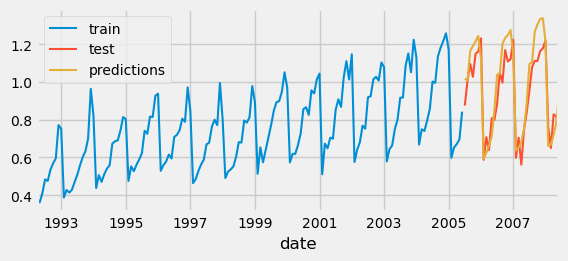

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'], 
                y_pred = predictions
            )
print(f"Test error (MSE) {error_mse}")

Test error (MSE) 0.01179296546962313


## Prediction intervals

A prediction interval defines the interval within which the true value of the target variable can be expected to be found with a given probability. Rob J Hyndman and George Athanasopoulos, in their book Forecasting: Principles and Practice, list [multiple ways to estimate prediction intervals](https://otexts.com/fpp2/prediction-intervals.html), most of which require that the residuals (errors) of the model to be normally distributed. If this cannot be assumed, one can resort to bootstrapping, which requires only that the residuals be uncorrelated. This is one of the methods available in skforecast. A more detailed explanation of prediction intervals can be found in the [Probabilistic forecasting: prediction intervals and prediction distribution](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/probabilistic-forecasting.html) user guide.

In [ ]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(alpha=0.1, random_state=765),
                 lags      = 15
             )
forecaster.fit(y=data_train['y'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                  steps    = steps,
                  interval = [1, 99],
                  n_boot   = 500
              )
predictions.head(5)

,pred,lower_bound,upper_bound
2005-07-01,0.970598,0.832599,1.087139
2005-08-01,0.990932,0.853038,1.110894
2005-09-01,1.149609,1.009519,1.270016
2005-10-01,1.194584,1.071910,1.321075
2005-11-01,1.231744,1.083885,1.356999


Test error (MSE): 0.010465086161791187


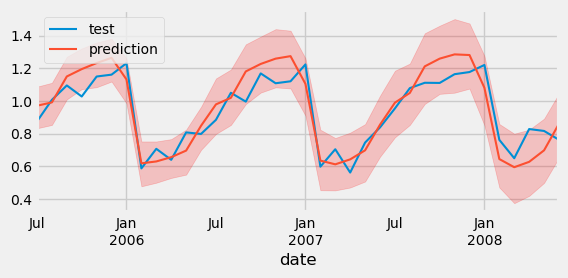

In [ ]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (MSE): {error_mse}")

# Plot forecasts with prediction intervals
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend(loc='upper left');

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_squared_error
0,0.012641


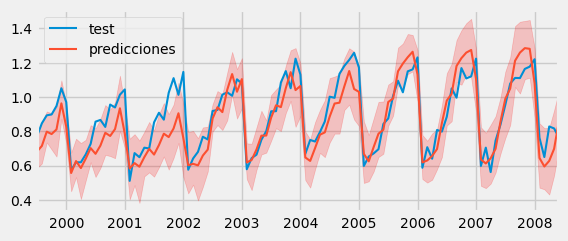

In [ ]:
# Backtest with prediction intervals
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(alpha=0.1, random_state=765),
                 lags      = 15
             )
cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = len(data) - 12 * 9,
         fixed_train_size   = False,
         refit              = True,
)
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            cv                 = cv,
                            metric             = 'mean_squared_error',
                            interval           = [1, 99],
                            n_boot             = 100,
                            n_jobs             = 'auto',
                            verbose            = True
                       )
display(metric)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data.loc[predictions.index, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                      (data.loc[predictions.index, 'y'] >= predictions['lower_bound']) & \
                      (data.loc[predictions.index, 'y'] <= predictions['upper_bound']),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 84.26 %


## Custom metric

In the backtesting (backtesting_forecaster) and hyperparameter optimization (grid_search_forecaster) processes, besides the frequently used metrics such as mean_squared_error or mean_absolute_error.

The following example shows how to forecast a 12-month horizon but considering **only the last 3 months of each year** to calculate the interest metric.

In [ ]:
# Custom metric 
# ==============================================================================
def custom_metric(y_true, y_pred):
    """
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

# Backtesting 
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    cv                 = cv,
                                    metric             = custom_metric,
                                    n_jobs             = 'auto',
                                    verbose            = True
                                 )
metric

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,custom_metric
0,0.128159


## Save and load models

Skforecast models can be stored and loaded from disck using pickle or joblib library. To simply the process, two functions are available: save_forecaster and load_forecaster, simple example is shown below. For more detailed documentation, visit: [skforecast save and load forecaster](https://skforecast.org/latest/user_guides/save-load-forecaster.html).

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterRecursive(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

In [ ]:
# Save forecaster
# ==============================================================================
save_forecaster(forecaster, file_name='forecaster.joblib', verbose=False)

In [ ]:
# Load forecaster
# ==============================================================================
forecaster_loaded = load_forecaster('forecaster.joblib')

ForecasterRecursive 
Regressor: RandomForestRegressor 
Lags: [1 2 3] 
Window features: None 
Window size: 3 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-01 16:07:05 
Last fit date: 2024-12-01 16:07:05 
Skforecast version: 0.14.0 
Python vers

In [ ]:
# Predict
# ==============================================================================
forecaster_loaded.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

## Use forecaster in production

Suppose predictions have to be generated on a weekly basis, for example, every Monday. By default, when using the predict method on a trained forecaster object, predictions start right after the last training observation. Therefore, the model could be retrained weekly, just before the first prediction is needed, and call its predict method.

Every model generated using skforecast has the last_window argument in its predict method. Using this argument, it is possible to provide only the past values needs to create the autoregressive predictors (lags) and thus, generate the predictions without the need to retrain the model.

For more detailed documentation, visit: [skforecast forecaster in production](https://skforecast.org/latest/user_guides/forecaster-in-production.html).

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['y'])

Since the model uses the last 6 lags as predictors, last_window must contain at least the 6 values previous to the moment where the prediction starts.

In [ ]:
# Predict with last window
# ==============================================================================
last_window = data_test['y'][-6:]
print(last_window)
forecaster.predict(last_window=last_window, steps=4)

date
2008-01-01    1.219941
2008-02-01    0.761822
2008-03-01    0.649435
2008-04-01    0.827887
2008-05-01    0.816255
2008-06-01    0.762137
Freq: MS, Name: y, dtype: float64


2008-07-01    0.757750
2008-08-01    0.836313
2008-09-01    0.877668
2008-10-01    0.911734
Freq: MS, Name: pred, dtype: float64

If the forecaster uses exogenous variables, besides last_window, the argument exog must contain the future values of the exogenous variables.